# Problem Set 4

In [36]:
import numpy as np

import pandas as pd

import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Problem A: Import and Clean the data

Import 100 records from the NYC yellow cab data set. We're going to be looking at the relationship between pickup location ID and tip amount. Are passengers from certain areas tipping better than others?

The data set can be found here:
<http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml>

In [77]:
data = pd.read_csv("yellow_tripdata_2017-01.csv", nrows=100000)

In [78]:
# Get a view of the data frame
df = data[['PULocationID','tip_amount']]

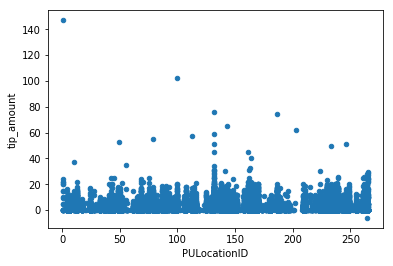

In [79]:
data.plot(x='PULocationID', y='tip_amount', kind='scatter')

## Remove the people who tipped nothing

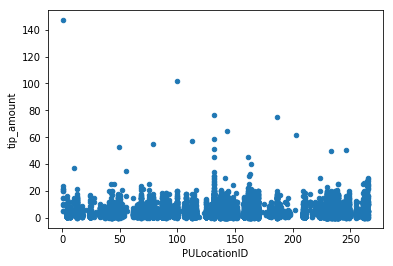

In [80]:
df = data[data.tip_amount > 0]
df.plot(x='PULocationID', y='tip_amount', kind='scatter')

## Problem B: Create a new column with the Buroughs

Since the pickup location is not really informative, we'll replace the location id with the Burough. There is a data file containing the relationship between the pickup location ID and the Burough at
<http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml>
Import it into a new data frame and create a new column in your previous data frame called "PUBurough" that contains the Burough corresponding to the PUlocationID.


In [81]:
burough_data = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")
burough_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [82]:
merge_df = df.merge(burough_data, left_on='PULocationID', right_on='LocationID', how='left')
merge_df['Borough'] = merge_df['Borough'].astype('category')
merge_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,LocationID,Borough,Zone,service_zone
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,...,0.0,0.5,2.00,0.0,0.3,15.30,263,Manhattan,Yorkville West,Yellow Zone
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,...,0.0,0.5,1.45,0.0,0.3,7.25,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,...,0.0,0.5,1.00,0.0,0.3,7.30,164,Manhattan,Midtown South,Yellow Zone
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,...,0.0,0.5,1.70,0.0,0.3,8.50,236,Manhattan,Upper East Side North,Yellow Zone
4,2,2017-01-01 00:00:02,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,...,0.5,0.5,4.66,0.0,0.3,27.96,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone


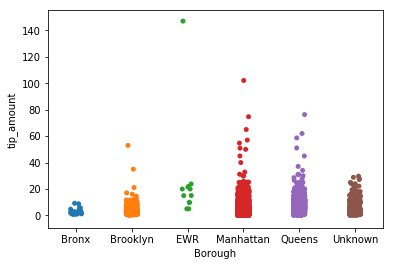

In [83]:
sns.stripplot(x="Borough", y="tip_amount", data=merge_df, jitter=True)

# Split into testing and training data

In [84]:
X = pd.get_dummies(merge_df['Borough'])
y = merge_df['tip_amount']
X.head()

,Bronx,Brooklyn,EWR,Manhattan,Queens,Unknown
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


## Fit Linear Regression

In [85]:
linreg=LinearRegression(fit_intercept=False)
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

## Look at the regression coefficients

In [86]:
print(linreg.intercept_)
print(linreg.coef_)
merge_df.groupby(['Borough'])['tip_amount'].mean()

0.0
[ 2.7453125   3.44331593 26.15833333  2.44736931  7.650811    3.48460317]


Borough
Bronx         2.745313
Brooklyn      3.443316
EWR          26.158333
Manhattan     2.447369
Queens        7.650811
Unknown       3.484603
Name: tip_amount, dtype: float64

## Evaluate the model

In [87]:
scores = cross_validate(linreg, X, y, cv=10, scoring='neg_median_absolute_error', return_train_score=False)
scores

{'fit_time': array([0.01459694, 0.02769923, 0.02345276, 0.01972675, 0.0176785 ,
        0.01417279, 0.01963806, 0.00636125, 0.00635195, 0.006356  ]),
 'score_time': array([0.00789309, 0.0051899 , 0.00191808, 0.00192857, 0.00155807,
        0.00142169, 0.00094151, 0.00080371, 0.00095439, 0.00079036]),
 'test_score': array([-1.14481008, -1.05529662, -1.00694634, -0.98745237, -0.99214787,
        -1.01113861, -0.99984982, -0.99870124, -0.99677629, -1.00137077])}

In [88]:
np.mean(-1*scores['test_score'])

1.0194490002311496